In [110]:
import os
import cv2

In [111]:
# os.chdir("..")

In [81]:
folder_path = "SkyFusion/train"
images = []
for image_name in os.listdir(folder_path):
    if image_name.endswith((".jpg",".jpeg",".png")):
        image_path = os.path.join(folder_path,image_name)
        img = cv2.imread(image_path)
        images.append(img)
print(f"{len(images)} in the train folder")

2094 in the train folder


In [82]:
import pandas as pd
import numpy as np
import json

In [83]:
def create_annotation_df(annotation_path):
    with open(annotation_path) as f:
        coco = json.load(f)
    images_df = pd.json_normalize(coco["images"])
    categories_df = pd.json_normalize(coco["categories"])
    annotations_df = pd.json_normalize(coco["annotations"])
    return images_df,categories_df,annotations_df

train_images_df,train_categories_df,train_annotaions_df = create_annotation_df("/Volumes/Local Disk A/Object_Detection_Assignment/annotations/train_annotations.coco.json")
val_images_df,val_categories_df,val_annotaions_df = create_annotation_df("/Volumes/Local Disk A/Object_Detection_Assignment/annotations/val_annotations.coco.json")
test_images_df,test_categories_df,test_annotaions_df = create_annotation_df("/Volumes/Local Disk A/Object_Detection_Assignment/annotations/test_annotations.coco.json")


In [84]:
train_images_df['file_name'][100]

'13433_png_jpg.rf.09c234aa23fba80b9693031fa28c8a73.jpg'

In [85]:
def bbox_coco2yolo(bbox:list,image_width,image_height,class_id:int):
    xmin = bbox[0]
    ymin = bbox[1]
    w_bbox = bbox[2]
    h_bbox = bbox[3]

    #yolo format:[xcenter,ycenter,w,h]
    xcenter = xmin+w_bbox/2
    ycenter = ymin+h_bbox/2

    #normalize to get final yolo format
    Cx = xcenter/image_width
    Cy = ycenter/image_height
    w = w_bbox/image_width
    h = h_bbox/image_height
    bbox_yolo = [class_id,Cx,Cy,w,h]
    return bbox_yolo

In [86]:
bbox_coco2yolo([259, 49, 4.8, 9.6],640,640,1)

[1, 0.40843749999999995, 0.0840625, 0.0075, 0.015]

In [87]:
def bbox_dictionary(annotations_df):
    bbox_dict = {}
    for i, row in annotations_df.iterrows():
        image_id = str(row['image_id'])  # use string as key
        yolo_bbox = bbox_coco2yolo(row['bbox'], 640, 640, row['category_id'])
        
        if image_id not in bbox_dict:
            bbox_dict[image_id] = []
        bbox_dict[image_id].append(yolo_bbox)
    return bbox_dict

train_bbox_dictionary = bbox_dictionary(train_annotaions_df)
val_bbox_dictionary = bbox_dictionary(val_annotaions_df)
test_bbox_dictionary = bbox_dictionary(test_annotaions_df)


In [88]:
def yolo_df(images_df,bbox_dictionary):
    yolo_format_df = pd.DataFrame({
        'filename': images_df['file_name'].tolist(),
        'image_id': list(bbox_dictionary.keys()),
        "bboxes": list(bbox_dictionary.values())
    })
    return yolo_format_df
train_yolo_format_df = yolo_df(train_images_df,train_bbox_dictionary)
val_yolo_format_df = yolo_df(val_images_df,val_bbox_dictionary)
test_yolo_format_df = yolo_df(test_images_df,test_bbox_dictionary)

In [89]:
train_yolo_format_df.iloc[1945]

filename    19398_png_jpg.rf.c8b9e2fafbf389ee1579f3363ebcc...
image_id                                                 1945
bboxes      [[3, 0.4453125, 0.25125000000000003, 0.01875, ...
Name: 1945, dtype: object

In [90]:
output_dir = "labels"
os.makedirs(output_dir, exist_ok=True)

def create_txt_files(images_df,yolo_format_df):
    for image_name in images_df['file_name'].tolist():
        name, ext = os.path.splitext(image_name)
        
        # Find the row in yolo_format_df corresponding to this image
        row = yolo_format_df[yolo_format_df['filename'] == image_name]
        
        if not row.empty:
            bboxes_list = row.iloc[0]['bboxes']  # this is a list of bounding boxes
            
            # Write each bounding box in a new line
            with open(os.path.join(output_dir, name + ".txt"), "w") as f:
                for bbox in bboxes_list:
                    # If bbox is a list like [class, x_center, y_center, width, height]
                    f.write(" ".join(map(str, bbox)) + "\n")
    return f



In [91]:
def save_yolo_txt_files(images_df, yolo_format_df, output_dir="labels"):
    """
    Save YOLO-format text files for each image.
    
    Parameters:
        images_df (pd.DataFrame): DataFrame with at least 'file_name' column.
        yolo_format_df (pd.DataFrame): DataFrame with 'filename' and 'bboxes' columns.
                                       'bboxes' must be a list of [class, x_center, y_center, width, height].
        output_dir (str): Directory to save YOLO txt files.
    """
    os.makedirs(output_dir, exist_ok=True)

    for _, row in images_df.iterrows():
        image_name = row['file_name']
        name, _ = os.path.splitext(image_name)

        # Find the row in yolo_format_df corresponding to this image
        match = yolo_format_df[yolo_format_df['filename'] == image_name]

        if not match.empty:
            bboxes_list = match.iloc[0]['bboxes']  # list of bounding boxes

            # Save to txt file
            file_path = os.path.join(output_dir, name + ".txt")
            with open(file_path, "w") as f:
                for bbox in bboxes_list:
                    f.write(" ".join(map(str, bbox)) + "\n")

    print(f"YOLO annotation txt files saved in: {output_dir}")

save_yolo_txt_files(train_images_df,train_yolo_format_df,"labels/train")
save_yolo_txt_files(val_images_df,val_yolo_format_df,"labels/val")
save_yolo_txt_files(test_images_df,test_yolo_format_df,"labels/test")

YOLO annotation txt files saved in: labels/train
YOLO annotation txt files saved in: labels/val
YOLO annotation txt files saved in: labels/test


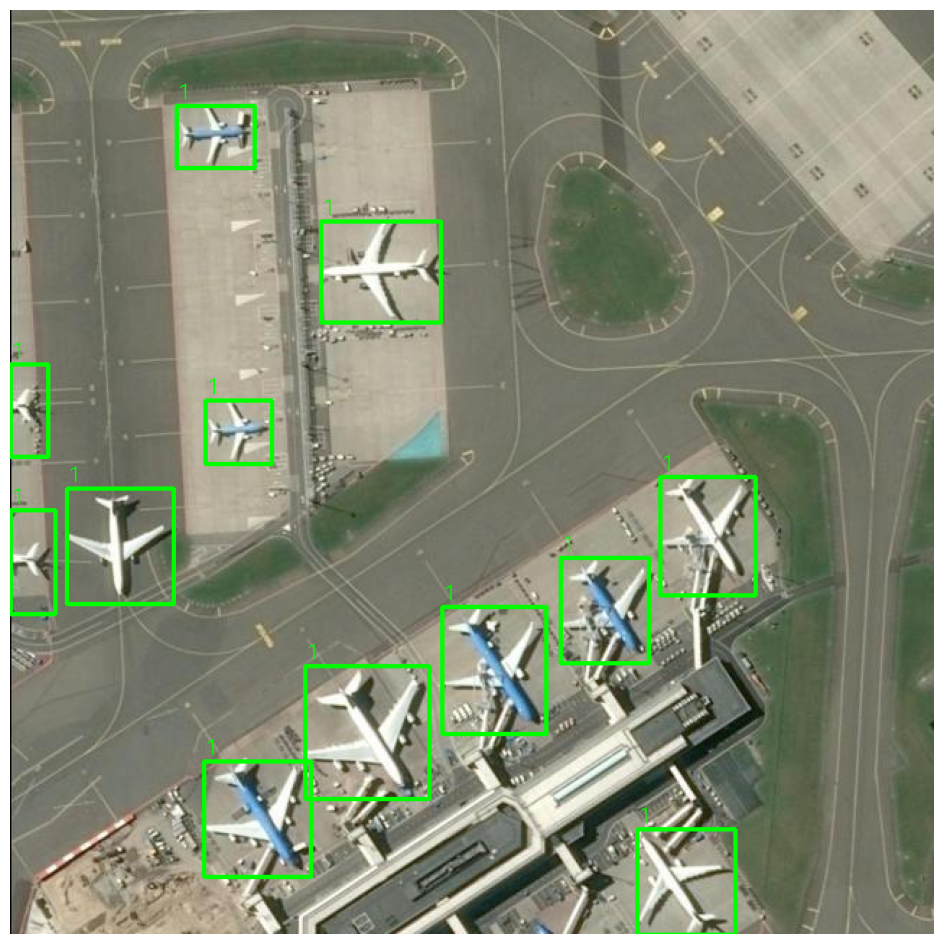

In [92]:
import cv2
import matplotlib.pyplot as plt

# Paths
image_path = os.path.join(folder_path, "d8873734-016a-4b9d-9b9e-8bc47eb13fef_1060_0_jpg.rf.e71d39eb3591437408a541ce8d91b7f3.jpg")
txt_path = os.path.join("labels/train", "d8873734-016a-4b9d-9b9e-8bc47eb13fef_1060_0_jpg.rf.e71d39eb3591437408a541ce8d91b7f3.txt")

# Load image
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib
h, w = img.shape[:2]

# Read YOLO bboxes
with open(txt_path, "r") as f:
    lines = f.readlines()

for line in lines:
    cls, x_center, y_center, width, height = map(float, line.strip().split())
    
    # Convert YOLO format to pixel coordinates
    x_center_pixel = x_center * w
    y_center_pixel = y_center * h
    width_pixel = width * w
    height_pixel = height * h

    # Get top-left and bottom-right corners
    x1 = int(x_center_pixel - width_pixel / 2)
    y1 = int(y_center_pixel - height_pixel / 2)
    x2 = int(x_center_pixel + width_pixel / 2)
    y2 = int(y_center_pixel + height_pixel / 2)
    
    # Draw rectangle
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    # Put class label
    cv2.putText(img, str(int(cls)), (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)

# Show image inline
plt.figure(figsize=(12,12))
plt.imshow(img)
plt.axis('off')
plt.show()


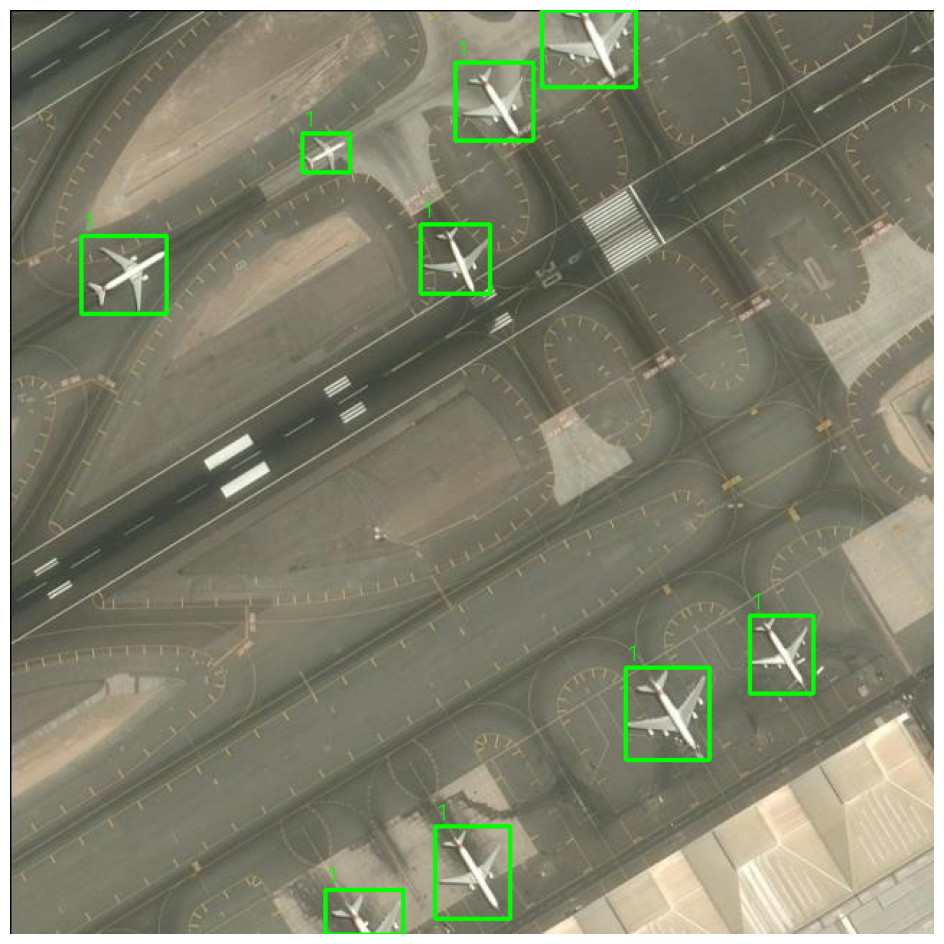

In [93]:
import cv2
import matplotlib.pyplot as plt

# Paths
image_path = os.path.join(folder_path, "2314c1b5-ec8f-4212-b42f-43365a13fd20_1060_0_jpg.rf.dfa6007af52759b2ab85b7f0054394f2.jpg")
txt_path = os.path.join("labels/train", "2314c1b5-ec8f-4212-b42f-43365a13fd20_1060_0_jpg.rf.dfa6007af52759b2ab85b7f0054394f2.txt")

# Load image
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib
h, w = img.shape[:2]

# Read YOLO bboxes
with open(txt_path, "r") as f:
    lines = f.readlines()

for line in lines:
    cls, x_center, y_center, width, height = map(float, line.strip().split())
    
    # Convert YOLO format to pixel coordinates
    x_center_pixel = x_center * w
    y_center_pixel = y_center * h
    width_pixel = width * w
    height_pixel = height * h

    # Get top-left and bottom-right corners
    x1 = int(x_center_pixel - width_pixel / 2)
    y1 = int(y_center_pixel - height_pixel / 2)
    x2 = int(x_center_pixel + width_pixel / 2)
    y2 = int(y_center_pixel + height_pixel / 2)
    
    # Draw rectangle
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    # Put class label
    cv2.putText(img, str(int(cls)), (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)

# Show image inline
plt.figure(figsize=(12,12))
plt.imshow(img)
plt.axis('off')
plt.show()


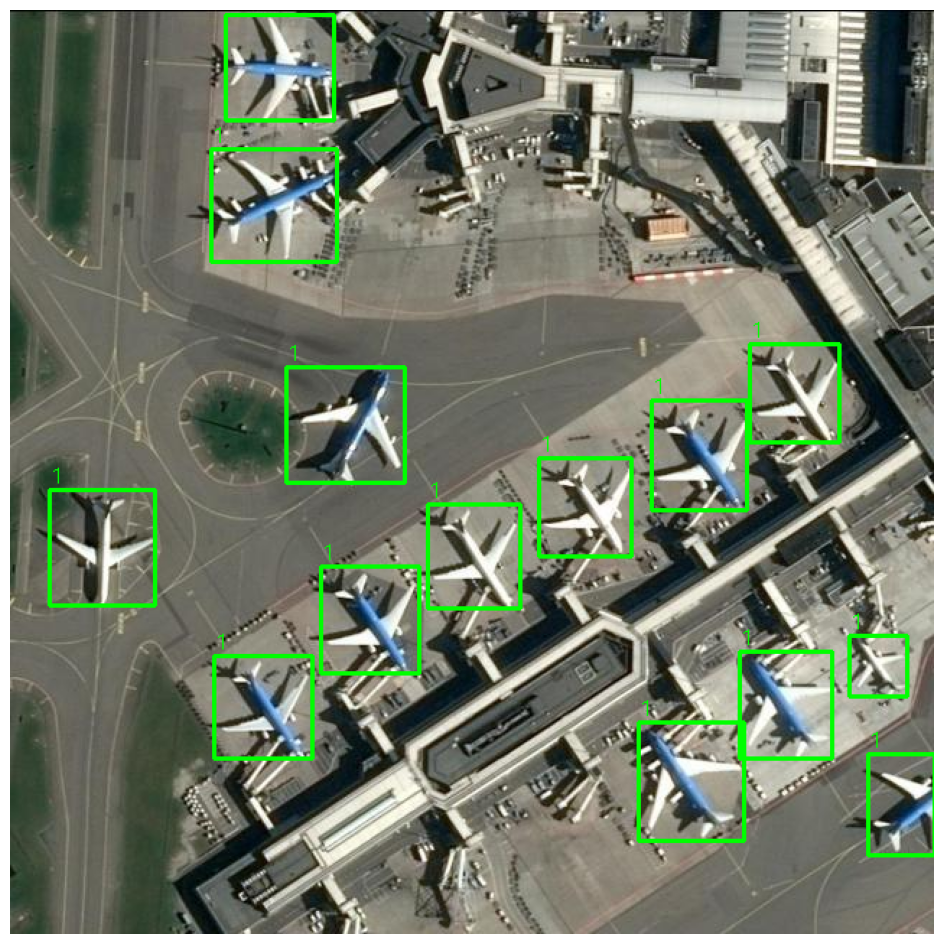

In [94]:
import cv2
import matplotlib.pyplot as plt

# Paths
image_path = os.path.join("SkyFusion/test", "3da0b873-fdde-4faf-9a85-021248c7dacf_0_0_jpg.rf.527df3159a006817a6772776e09abc2e.jpg")
txt_path = os.path.join("labels/test", "3da0b873-fdde-4faf-9a85-021248c7dacf_0_0_jpg.rf.527df3159a006817a6772776e09abc2e.txt")

# Load image
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib
h, w = img.shape[:2]

# Read YOLO bboxes
with open(txt_path, "r") as f:
    lines = f.readlines()

for line in lines:
    cls, x_center, y_center, width, height = map(float, line.strip().split())
    
    # Convert YOLO format to pixel coordinates
    x_center_pixel = x_center * w
    y_center_pixel = y_center * h
    width_pixel = width * w
    height_pixel = height * h

    # Get top-left and bottom-right corners
    x1 = int(x_center_pixel - width_pixel / 2)
    y1 = int(y_center_pixel - height_pixel / 2)
    x2 = int(x_center_pixel + width_pixel / 2)
    y2 = int(y_center_pixel + height_pixel / 2)
    
    # Draw rectangle
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    # Put class label
    cv2.putText(img, str(int(cls)), (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)

# Show image inline
plt.figure(figsize=(12,12))
plt.imshow(img)
plt.axis('off')
plt.show()


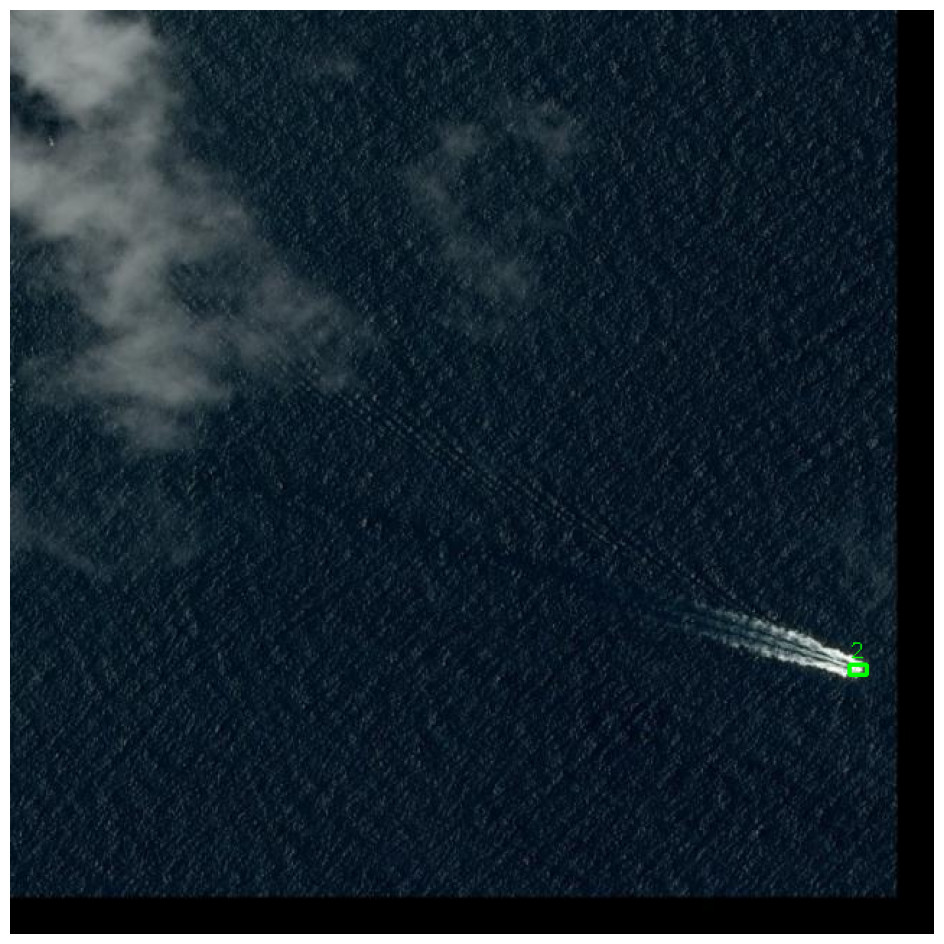

In [95]:
import cv2
import matplotlib.pyplot as plt

# Paths
image_path = os.path.join("SkyFusion/test", "0cfbcc901_png_jpg.rf.176590d10fb5cdb51b42b623a42d731a.jpg")
txt_path = os.path.join("labels/test", "0cfbcc901_png_jpg.rf.176590d10fb5cdb51b42b623a42d731a.txt")

# Load image
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib
h, w = img.shape[:2]

# Read YOLO bboxes
with open(txt_path, "r") as f:
    lines = f.readlines()

for line in lines:
    cls, x_center, y_center, width, height = map(float, line.strip().split())
    
    # Convert YOLO format to pixel coordinates
    x_center_pixel = x_center * w
    y_center_pixel = y_center * h
    width_pixel = width * w
    height_pixel = height * h

    # Get top-left and bottom-right corners
    x1 = int(x_center_pixel - width_pixel / 2)
    y1 = int(y_center_pixel - height_pixel / 2)
    x2 = int(x_center_pixel + width_pixel / 2)
    y2 = int(y_center_pixel + height_pixel / 2)
    
    # Draw rectangle
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    # Put class label
    cv2.putText(img, str(int(cls)), (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)

# Show image inline
plt.figure(figsize=(12,12))
plt.imshow(img)
plt.axis('off')
plt.show()


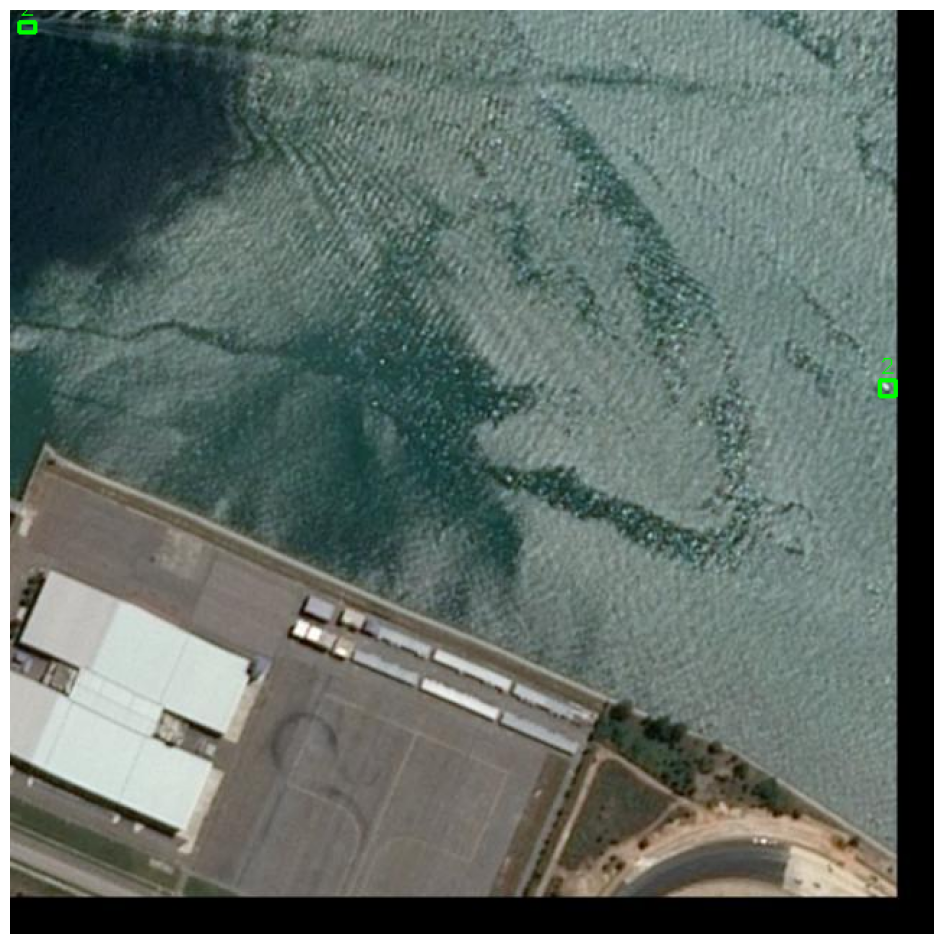

In [96]:
import cv2
import matplotlib.pyplot as plt

# Paths
image_path = os.path.join("/Volumes/Local Disk A/Object_Detection_Assignment/SkyFusion/val", "0aa4c741c_png_jpg.rf.c15a185c3c4b06ae5d38be866343cc01.jpg")
txt_path = os.path.join("/Volumes/Local Disk A/Object_Detection_Assignment/labels/val", "0aa4c741c_png_jpg.rf.c15a185c3c4b06ae5d38be866343cc01.txt")

# Load image
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib
h, w = img.shape[:2]

# Read YOLO bboxes
with open(txt_path, "r") as f:
    lines = f.readlines()

for line in lines:
    cls, x_center, y_center, width, height = map(float, line.strip().split())
    
    # Convert YOLO format to pixel coordinates
    x_center_pixel = x_center * w
    y_center_pixel = y_center * h
    width_pixel = width * w
    height_pixel = height * h

    # Get top-left and bottom-right corners
    x1 = int(x_center_pixel - width_pixel / 2)
    y1 = int(y_center_pixel - height_pixel / 2)
    x2 = int(x_center_pixel + width_pixel / 2)
    y2 = int(y_center_pixel + height_pixel / 2)
    
    # Draw rectangle
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    # Put class label
    cv2.putText(img, str(int(cls)), (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)

# Show image inline
plt.figure(figsize=(12,12))
plt.imshow(img)
plt.axis('off')
plt.show()


In [97]:
print(train_annotaions_df['category_id'].value_counts())
print(test_annotaions_df['category_id'].value_counts())
print(val_annotaions_df['category_id'].value_counts())

category_id
3    33396
1     8696
2     1483
Name: count, dtype: int64
category_id
3    9377
1    1968
2     406
Name: count, dtype: int64
category_id
3    6142
1    1957
2     288
Name: count, dtype: int64


In [98]:
train_yolo_format_df.head()

filename image_id  \
0  P2491__1-0__1200___1764_png_jpg.rf.00342c6c14a...        0   
1  4f833867-273e-4d73-8bc3-cb2d9ceb54ef_0_0_jpg.r...        1   
2  P2251__1-0__0___0_png_jpg.rf.00725f2361985a2ea...        2   
3  ecfe7982-05e5-435f-824b-e24b6846316e_1060_0_jp...        3   
4  P1384__1-0__0___3000_png_jpg.rf.0063aeee45ef5b...        4   

                                              bboxes  
0  [[3, 0.40843749999999995, 0.0840625, 0.0075, 0...  
1  [[1, 0.375, 0.87421875, 0.053125, 0.0734375], ...  
2  [[3, 0.5128125, 0.54875, 0.01, 0.01], [3, 0.51...  
3  [[1, 0.54765625, 0.012109375, 0.0421875, 0.021...  
4  [[3, 0.1715625, 0.046875, 0.008749999999999999...

In [99]:
import yaml
import os

def create_yolo_yaml(categories_df, images_path, output_path="dataset.yaml", 
                     val_path=None, test_path=None):
    """
    Create a YOLO dataset YAML file from COCO categories dataframe.
    
    Parameters:
        categories_df (pd.DataFrame): Must have 'id' and 'name' columns.
        images_path (str): Path to training images folder.
        output_path (str): Path to save YAML file.
        val_path (str): Path to validation images folder.
        test_path (str): Path to test images folder (optional).
    """
    class_names = categories_df['name'].tolist()
    nc = len(class_names)

    dataset_dict = {
        "train": images_path,
        "val": val_path if val_path else images_path,  # fallback to train path
        "test": test_path if test_path else "",        # optional
        "nc": nc,
        "names": class_names
    }

    with open(output_path, "w") as f:
        yaml.dump(dataset_dict, f, default_flow_style=False)

    print(f"✅ YOLO dataset YAML created at: {output_path}")
    return dataset_dict


create_yolo_yaml(
    categories_df=train_categories_df,
    images_path="/Volumes/Local Disk A/Object_Detection_Assignment/SkyFusion/train",
    val_path="/Volumes/Local Disk A/Object_Detection_Assignment/SkyFusion/val",
    test_path="/Volumes/Local Disk A/Object_Detection_Assignment/SkyFusion/test",
    output_path="../dataset.yaml"
)


✅ YOLO dataset YAML created at: ../dataset.yaml


{'train': '/Volumes/Local Disk A/Object_Detection_Assignment/SkyFusion/train',
 'val': '/Volumes/Local Disk A/Object_Detection_Assignment/SkyFusion/val',
 'test': '/Volumes/Local Disk A/Object_Detection_Assignment/SkyFusion/test',
 'nc': 3,
 'names': ['Aircraft', 'ship', 'vehicle']}

In [100]:
!git clone https://github.com/ultralytics/yolov5

fatal: destination path 'yolov5' already exists and is not an empty directory.


In [112]:
%cd yolov5

/Volumes/Local Disk A/Object_Detection_Assignment/yolov5


In [ ]:
!pip install -r requirements.txt


[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [115]:
import os

# Paths to your label folders
label_dirs = [
    "/Volumes/Local Disk A/Object_Detection_Assignment/SkyFusion/train",
    "/Volumes/Local Disk A/Object_Detection_Assignment/SkyFusion/val"
]

# Mapping: incorrect class -> correct class
class_mapping = {
    1: 0,
    2: 1,
    3: 2
}

for folder in label_dirs:
    for file in os.listdir(folder):
        if file.endswith(".txt"):
            path = os.path.join(folder, file)
            lines = []
            with open(path, "r") as f:
                for line in f:
                    parts = line.strip().split()
                    cls = int(parts[0])
                    if cls in class_mapping:
                        parts[0] = str(class_mapping[cls])
                    lines.append(" ".join(parts))
            # Overwrite the file with updated labels
            with open(path, "w") as f:
                f.write("\n".join(lines))

print("All labels updated according to mapping: 1->0, 2->1, 3->2.")


All labels updated according to mapping: 1->0, 2->1, 3->2.


In [120]:
!python train.py --img 640 --batch 4 --epochs 1 --data ../dataset.yaml --cfg yolov3.yaml --weights yolov3.pt --device mps


train: weights=yolov3.pt, cfg=yolov3.yaml, data=../dataset.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=1, batch_size=4, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=mps, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: up to date with https://github.com/ultralytics/yolov5 ✅
fatal: cannot change to '/Volumes/Local': No such file or directory
YOLOv5 🚀 2025-9-17 Python-3.12.0 torch-2.8.0 MPS

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_

In [118]:
import torch

print(torch.__version__)
print("MPS available:", torch.backends.mps.is_available())


2.8.0
MPS available: True


In [122]:
!python val.py --weights runs/train/exp11/weights/best.pt --data ../dataset.yaml --img 640


val: data=../dataset.yaml, weights=['runs/train/exp11/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
fatal: cannot change to '/Volumes/Local': No such file or directory
YOLOv5 🚀 2025-9-17 Python-3.12.0 torch-2.8.0 CPU

Traceback (most recent call last):
  File "/Volumes/Local Disk A/Object_Detection_Assignment/yolov5/val.py", line 604, in <module>
    main(opt)
  File "/Volumes/Local Disk A/Object_Detection_Assignment/yolov5/val.py", line 575, in main
    run(**vars(opt))
  File "/Volumes/Local Disk A/Object_Detection_Assignment/object_detection/lib/python3.12/site-packages/torch/utils/_contextlib.py", line 120, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/Volumes/Local Disk A/Object_